In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, date_format
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests, datetime

spark = SparkSession.builder.appName("WeatherPlot").getOrCreate()


Download dataset

In [2]:
url = "https://raw.githubusercontent.com/Xiru1024/BigDataExercise/refs/heads/main/exampleData.csv"
local_path = "/home/jovyan/BigDataExercise/report1/weather.csv"
with open(local_path, "wb") as f:
    f.write(requests.get(url).content)

In [3]:
df = spark.read.option("header", True).csv("weather.csv")

Line plot for temperature over time

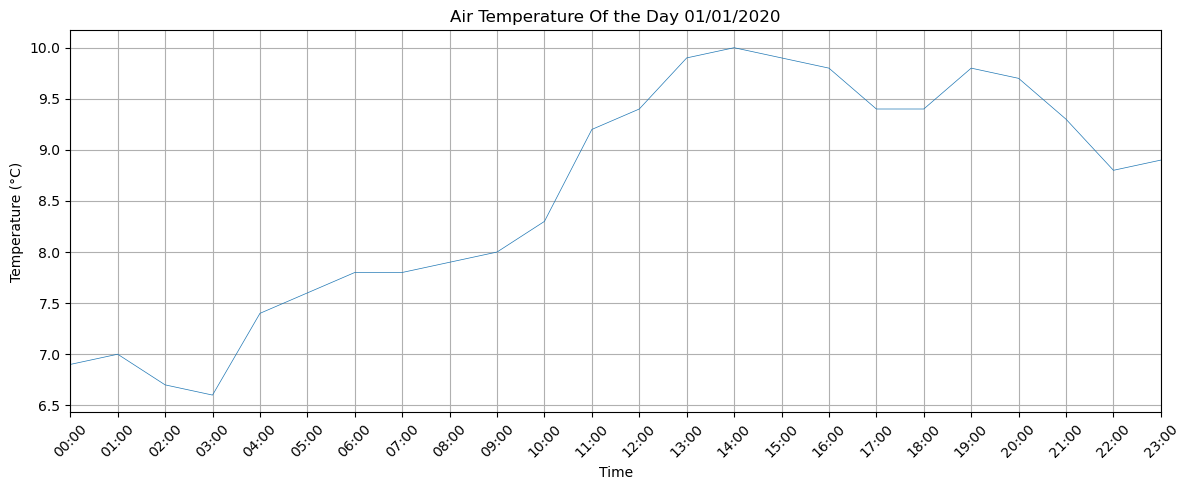

In [4]:
df_plot1 = (
    df.withColumn("dateTime", to_timestamp("dateTime", "dd-MMM-yyyy HH:mm"))
      .withColumn("air_temperature", col("air_temperature").cast("float"))
      .filter((col("air_temperature").isNotNull()) &
              (date_format("dateTime", "yyyy-MM-dd") == "2020-01-01"))
)

# df_plot1.show(n=df.count())
# writePath = "/home/jovyan/BigDataExercise/report1/plot1DF.csv"
# df_plot1.write.mode("overwrite").csv(writePath, header=True) 

df_plot1_panda = df_plot1.select("dateTime", "air_temperature").toPandas()

plt.figure(figsize=(12, 5))
plt.plot(df_plot1_panda["dateTime"], df_plot1_panda["air_temperature"], linewidth=0.5)
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlim(datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 23, 0))
plt.title("Air Temperature Of the Day 01/01/2020")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Plot 2 Histogram - Distribution of Speed

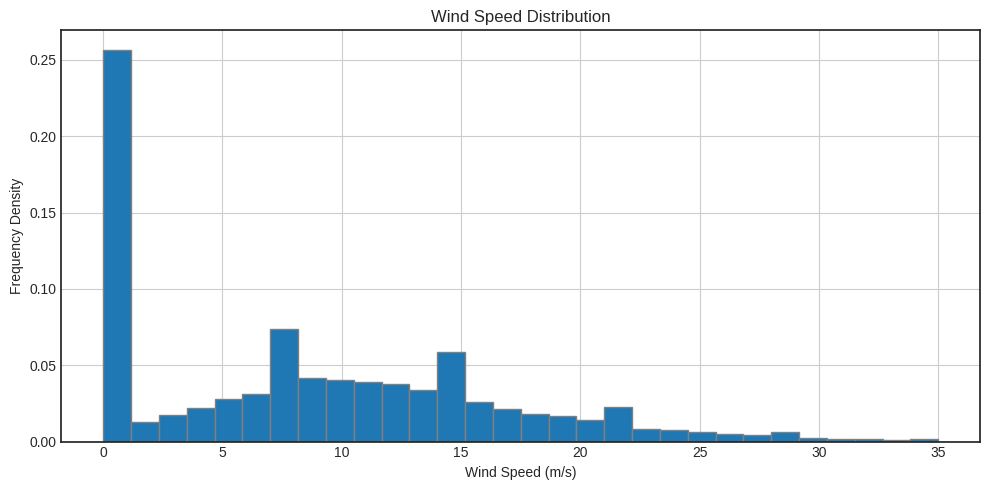

In [22]:
df_hist = (
    df.withColumn("wind_speed", col("wind_speed").cast("float"))
      .filter(col("wind_speed").isNotNull())
)

df_hist_panda = df_hist.select("wind_speed").toPandas()

plt.figure(figsize=(10, 5))
plt.hist(df_hist_panda["wind_speed"], bins=30, range=(0, 35), edgecolor='grey', density=True)
plt.title("Wind Speed Distribution")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency Density")
plt.grid(True)
plt.tight_layout()
plt.show()



Plot 3 - Scatter of temperature and humidty

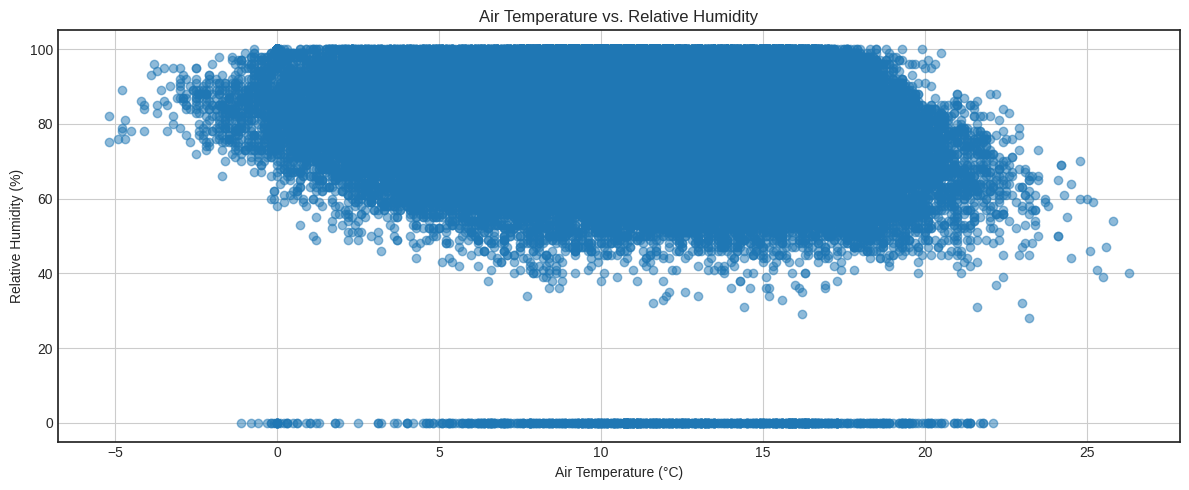

In [17]:
df_scatter = (
    df.withColumn("air_temperature", col("air_temperature").cast("float"))
      .withColumn("relative_humidity", col("relative_humidity").cast("float"))
      .filter(col("air_temperature").isNotNull() & col("relative_humidity").isNotNull())
)

df_scatter_panda = df_scatter.select("air_temperature", "relative_humidity").toPandas()


plt.figure(figsize=(10, 5))
plt.scatter(df_scatter_panda["air_temperature"], df_scatter_panda["relative_humidity"], alpha=0.5)
plt.title("Air Temperature vs. Relative Humidity")
plt.xlabel("Air Temperature (°C)")
plt.ylabel("Relative Humidity (%)")
plt.grid(True)
plt.tight_layout()
plt.show()



Plot4 - Monthly Rainfall barchart

+-----+------------------+
|month|        total_rain|
+-----+------------------+
|    1| 92.40000124275684|
|    2| 66.20000080764294|
|    3| 37.79999989271164|
|    4|30.599999457597733|
|    5| 48.00000037252903|
|    6|13.000000223517418|
|    7|34.600000366568565|
|    8| 8.200000166893005|
|    9|46.200000301003456|
|   10| 154.6000002771616|
|   11| 93.80000105500221|
|   12|162.80000077188015|
+-----+------------------+



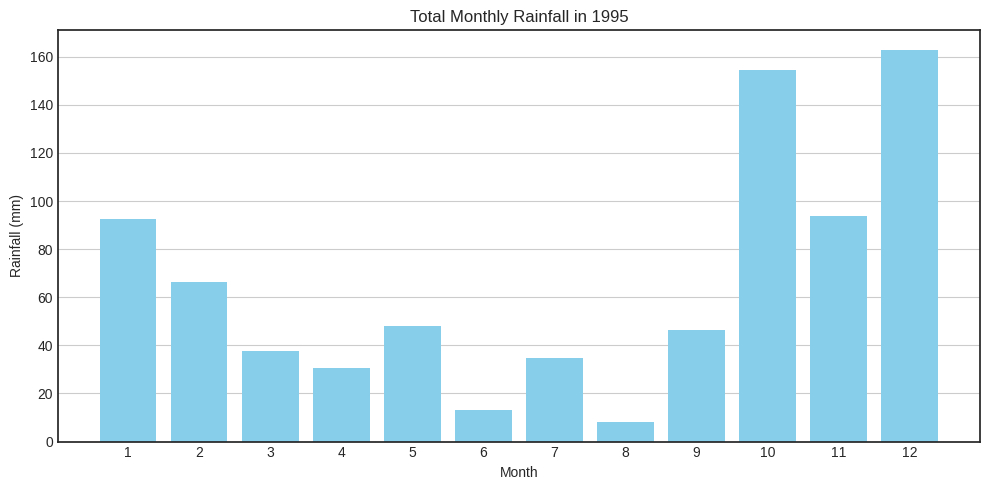

In [31]:

from pyspark.sql.functions import to_timestamp, col, month, year

# (df.select(to_timestamp("dateTime", "dd-MMM-yyyy HH:mm").alias("dt"))
#       .withColumn("year", year("dt"))
#       .groupBy("year").count().orderBy("year")
#       .show(n=df.count()))

# (df.withColumn("dateTime", to_timestamp("dateTime", "dd-MMM-yyyy HH:mm")) \
#   .withColumn("year", year("dateTime")) \
#   .withColumn("precipitation", col("precipitation").cast("float")) \
#   .filter((col("year") == 2020) & col("precipitation").isNotNull()) \
#   .count())


df_monthly_rain = (
    df.withColumn("dateTime", to_timestamp("dateTime", "dd-MMM-yyyy HH:mm"))
      .withColumn("precipitation", col("precipitation").cast("float"))
      .withColumn("month", month(col("dateTime")))
      .withColumn("year", year(col("dateTime")))
      .filter((col("year") == 1995) & col("precipitation").isNotNull())
      .groupBy("month")
      .sum("precipitation")
      .orderBy("month")
      .withColumnRenamed("sum(precipitation)", "total_rain")
)

df_monthly_rain.show()
df_monthly_rain_panda = df_monthly_rain.toPandas()

plt.figure(figsize=(10, 5))
plt.bar(df_monthly_rain_panda["month"], df_monthly_rain_panda["total_rain"], color='skyblue')
plt.xticks(df_monthly_rain_panda["month"])
plt.title("Total Monthly Rainfall in 1995")
plt.xlabel("Month")
plt.ylabel("Rainfall (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

